In [53]:
from __future__ import print_function
%matplotlib inline
#from __future__ import print_function
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from glob import glob
#import seaborn as sns
from scipy import stats
import matplotlib.mlab as mlab
#sns.set()
from astropy.wcs import WCS
from photutils import aperture_photometry,CircularAperture,CircularAnnulus
from astropy.stats import mad_std
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import photutils
import bottleneck
#photutils.test()
from astropy.utils.data import get_pkg_data_filename

In [34]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    
    table = Table.read(url, format='ascii')
    
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
        
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
        
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    
    if output_size:
        url = url + "&output_size={}".format(output_size)
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    
    if color:
        if len(table) > 3:
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
            
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
            
    return url



def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im



def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

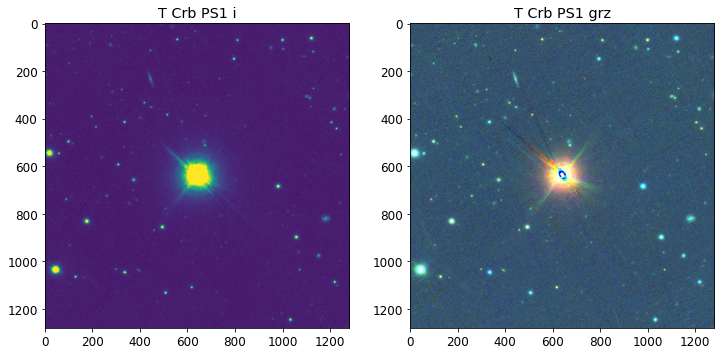

In [35]:
ra = 239.875610
dec = 25.920150
size = 1280


gim = getgrayim(ra,dec,size=size,filter="i")

cim = getcolorim(ra,dec,size=size,filters="grz")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('T Crb PS1 i')
pylab.subplot(122)
pylab.title('T Crb PS1 grz')
pylab.imshow(cim,origin="upper")

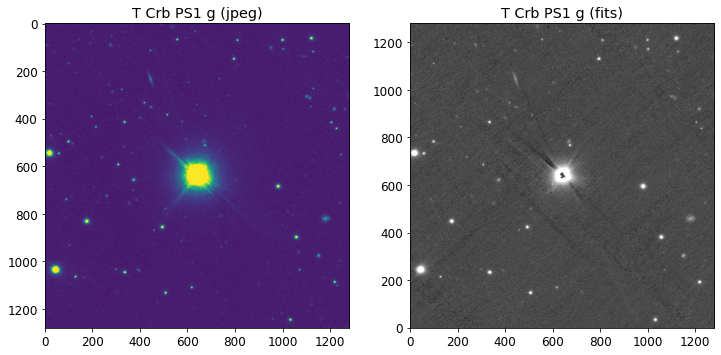

In [36]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch

fitsurl = geturl(ra, dec, size=size, filters="g", format="fits")
fh = fits.open(fitsurl[0])

#fh.writeto('T crb g.fits')
fim = fh[0].data

# replace NaN values with zero for display

fim[numpy.isnan(fim)] = 0.0
# set contrast to something reasonable

transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

pylab.figure(1,(12,6))

pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('T Crb PS1 g (jpeg)')



pylab.subplot(122)
pylab.title('T Crb PS1 g (fits)')
pylab.imshow(bfim,cmap="gray",origin="lower")

58.05724914104459